# Fintech name ideas:

## 1. BrokeFund

## 2. PayUpFront

## 3. NoFunds Inc


### Importing Libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

## Loading the PastLoans.csv dataset

In [110]:
past_loans = pd.read_csv('PastLoans.csv')

## Loading the NewApplications_Lender2_Round1.csv dataset

In [5]:
new_applicants = pd.read_csv('NewApplications_Lender2_Round1.csv')

### Number of defaulters by Sex

<Figure size 100x100 with 0 Axes>

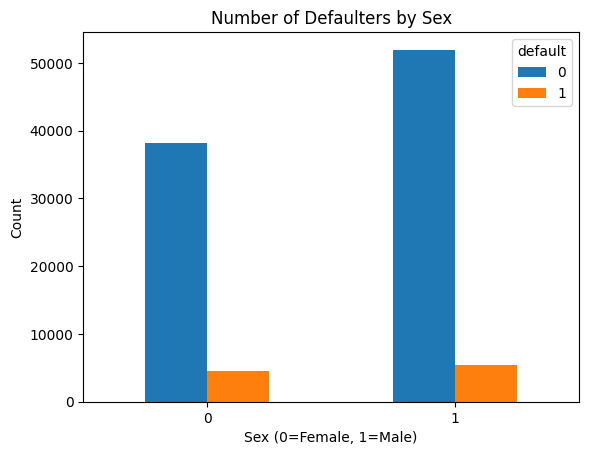

In [169]:
# Group by 'sex' and 'default', and count the occurrences
grouped_data = past_loans.groupby(['sex', 'default']).size().unstack()

plt.figure(figsize=(1, 1))

grouped_data.plot(kind='bar', stacked=False)

plt.title('Number of Defaulters by Sex')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.show()

### Number of defaulters by marital status

<Figure size 200x200 with 0 Axes>

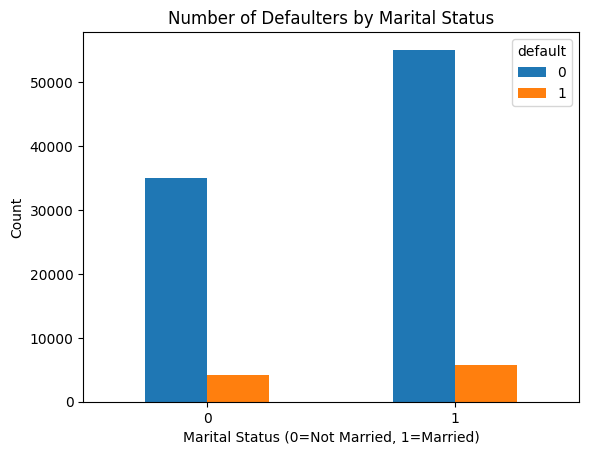

In [170]:
# Group by 'married' and 'default', and count the occurrences
grouped_data2 = past_loans.groupby(['married', 'default']).size().unstack()

plt.figure(figsize=(2, 2))
grouped_data2.plot(kind='bar', stacked=False)

# Add titles and labels
plt.title('Number of Defaulters by Marital Status')
plt.xlabel('Marital Status (0=Not Married, 1=Married)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.show()

### Number of defaulters by income range

/var/folders/2r/xjzdhv614ll26kt0l39p1gr00000gn/T/ipykernel_58808/3704477856.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = past_loans_income_bins.groupby(['income_bin', 'default']).size().unstack()


<Figure size 300x300 with 0 Axes>

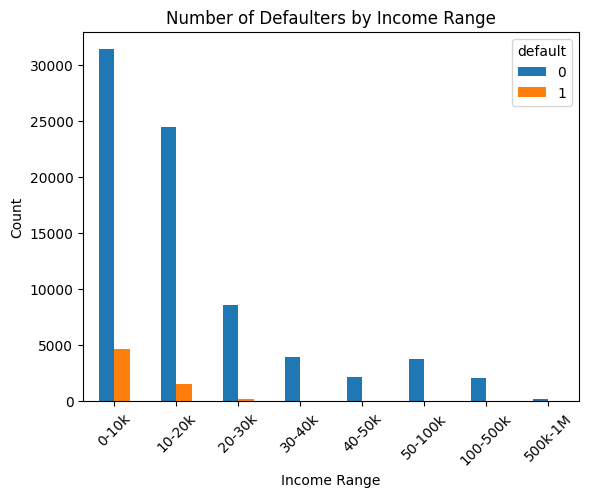

In [175]:
# Define smaller bins for people earning less than 50k, and larger bins for others
bins = [0, 10000, 20000, 30000, 40000, 50000, 100000, 500000, 1000000]
bin_labels = ['0-10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-100k', '100-500k', '500k-1M']

past_loans_income_bins = past_loans.copy()
# Create a new column 'income_bin' by binning the 'income' column
past_loans_income_bins['income_bin'] = pd.cut(past_loans_income_bins['income'], bins=bins, labels=bin_labels)

# Group by 'income_bin' and 'default', and count the occurrences
grouped_data = past_loans_income_bins.groupby(['income_bin', 'default']).size().unstack()

plt.figure(figsize=(3, 3))

grouped_data.plot(kind='bar', stacked=False)

# Add titles and labels
plt.title('Number of Defaulters by Income Range')
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()


### Imbalanced target

In [11]:
past_loans['default'].value_counts()

default
0    90053
1     9947
Name: count, dtype: int64

## Cleansing:

### Mapping the 'sex' feature and One Hot Encoding the 'employment' feature

In [176]:
# Step 1: Map 'sex' column
past_loans['sex'] = past_loans['sex'].map({'M': 1, 'F': 0})

# Step 2: One-hot encode the 'employment' column
encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False returns a dense array
employment_encoded = encoder.fit_transform(past_loans[['employment']])

# Step 3: Create a DataFrame for the encoded 'employment' columns
employment_encoded_df = pd.DataFrame(employment_encoded, columns=encoder.get_feature_names_out(['employment']))

# Step 4: Concatenate the original DataFrame with the new one-hot encoded 'employment' columns
past_loans_encoded = pd.concat([past_loans.drop('employment', axis=1), employment_encoded_df], axis=1)


## Baseline model: XGBOOST

In [68]:

# Prepare the data
X = past_loans_encoded.drop('default', axis=1)  # Features (drop the target column)
y = past_loans_encoded['default']  # Target (default column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(class_report)


/Users/tesscoullon/.pyenv/versions/3.10.6/envs/lending_game_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9020
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     18049
           1       0.45      0.02      0.04      1951

    accuracy                           0.90     20000
   macro avg       0.68      0.51      0.50     20000
weighted avg       0.86      0.90      0.86     20000



## Accuracy = 90

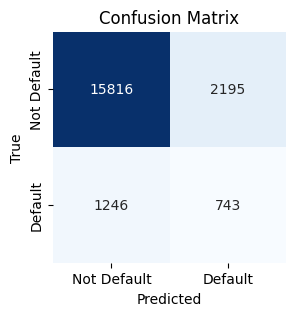

In [177]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Not Default', 'Default'], columns=['Not Default', 'Default'])

# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Creating interaction features

In [113]:
# Create interaction features
past_loans_encoded['married_employed'] = past_loans_encoded['married'] * past_loans_encoded['employment_employed']
past_loans_encoded['married_retired'] = past_loans_encoded['married'] * past_loans_encoded['employment_retired']
past_loans_encoded['married_student'] = past_loans_encoded['married'] * past_loans_encoded['employment_student']
past_loans_encoded['married_unemployed'] = past_loans_encoded['married'] * past_loans_encoded['employment_unemployed']


## Standardizing the income

In [114]:
scaler = StandardScaler()
past_loans_encoded['income_standardized'] = scaler.fit_transform(past_loans_encoded[['income']])

## Feature selection

In [122]:
features = [
    'sex', 'digital1', 'digital2', 'digital3',
    'employment_employed', 'employment_retired',
    'employment_student', 'employment_unemployed',
    'married_employed', 'married_retired', 'married_unemployed',
    'income_standardized'  # Keeping the standardized income
]

#features = [
 #   'sex', 'married', 'digital1', 'digital2', 'digital3',
  #  'employment_employed', 'employment_retired',
   # 'employment_student', 'employment_unemployed',
    #'married_employed', 'married_retired',
    #'married_student', 'married_unemployed',
    #'income_standardized'  # Keeping the standardized income
#]

X = past_loans_encoded[features]
y = past_loans_encoded['default']

## Second model

In [116]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)

/Users/tesscoullon/.pyenv/versions/3.10.6/envs/lending_game_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:20:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.902
Confusion Matrix:
 [[17987    62]
 [ 1898    53]]


## Accuracy = 90

# Balancing the target using SMOTE method

In [123]:
#X = past_loans_encoded.drop('default', axis=1)  # Features
#y = past_loans_encoded['default']                 # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy=0.5, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model on the resampled data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Calculate the model accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", report)
print(f"\nModel Accuracy: {accuracy:.4f}")  # Print the accuracy

/Users/tesscoullon/.pyenv/versions/3.10.6/envs/lending_game_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[15816  2195]
 [ 1246   743]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90     18011
           1       0.25      0.37      0.30      1989

    accuracy                           0.83     20000
   macro avg       0.59      0.63      0.60     20000
weighted avg       0.86      0.83      0.84     20000


Model Accuracy: 0.8279


## Accuracy = 83

## Feature importance

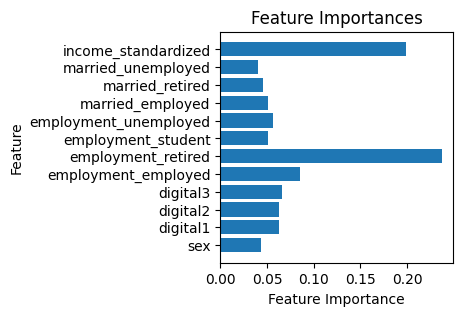

In [179]:
xgb_model.feature_importances_  # Get feature importances

plt.figure(figsize=(3, 3))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

# Third model and predictions for submission

In [180]:
# Step 1: Process past loans data
past_loans = pd.read_csv('PastLoans.csv')
past_loans['sex'] = past_loans['sex'].map({'M': 1, 'F': 0})

# One-hot encode the 'employment' column
encoder = OneHotEncoder(sparse_output=False)
employment_encoded = encoder.fit_transform(past_loans[['employment']])
employment_encoded_df = pd.DataFrame(employment_encoded, columns=encoder.get_feature_names_out(['employment']))

# Concatenate the encoded 'employment' columns
past_loans_encoded = pd.concat([past_loans.drop('employment', axis=1), employment_encoded_df], axis=1)

# Create interaction features
past_loans_encoded['married_employed'] = past_loans_encoded['married'] * past_loans_encoded['employment_employed']
past_loans_encoded['married_retired'] = past_loans_encoded['married'] * past_loans_encoded['employment_retired']
past_loans_encoded['married_student'] = past_loans_encoded['married'] * past_loans_encoded['employment_student']
past_loans_encoded['married_unemployed'] = past_loans_encoded['married'] * past_loans_encoded['employment_unemployed']

# Standardize 'income'
scaler = StandardScaler()
past_loans_encoded['income_standardized'] = scaler.fit_transform(past_loans_encoded[['income']])

# Define features and target
features = ['sex', 'digital1', 'digital2', 'digital3',
            'employment_employed', 'employment_retired',
            'employment_student', 'employment_unemployed',
            'married_employed', 'married_retired', 'married_unemployed', 
            'income_standardized']
X = past_loans_encoded[features]
y = past_loans_encoded['default']

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X, y)

# Step 2: Process new applicants
new_applicants_prepared = new_applicants.copy()

# Standardize 'income'
new_applicants_prepared['income_standardized'] = scaler.transform(new_applicants[['income']])

# Map 'sex' column
new_applicants_prepared['sex'] = new_applicants_prepared['sex'].map({'M': 1, 'F': 0})

# One-hot encode the 'employment' column for new applicants
employment_app_encoded = encoder.transform(new_applicants_prepared[['employment']])
employment_app_encoded_df = pd.DataFrame(employment_app_encoded, columns=encoder.get_feature_names_out(['employment']))

# Concatenate the encoded 'employment' columns
new_applicants_prepared = pd.concat([new_applicants_prepared.drop('employment', axis=1), employment_app_encoded_df], axis=1)

# Create interaction features for new applicants
new_applicants_prepared['married_employed'] = new_applicants_prepared['married'] * new_applicants_prepared['employment_employed']
new_applicants_prepared['married_retired'] = new_applicants_prepared['married'] * new_applicants_prepared['employment_retired']
new_applicants_prepared['married_student'] = new_applicants_prepared['married'] * new_applicants_prepared['employment_student']
new_applicants_prepared['married_unemployed'] = new_applicants_prepared['married'] * new_applicants_prepared['employment_unemployed']

new_applicants_prepared['digital1'] = np.nan

new_applicants_prepared['digital3'] = np.nan

# Step 3: Predict the probability of default
default_probabilities = xgb_model.predict_proba(new_applicants_prepared[features])[:, 1]  # Probability of default (class 1)

# Step 3: Compute the break-even interest rate with a condition on PD
def break_even_interest_rate(prob_default):
    # If probability of default is greater than 0.5, reject the loan (interest rate = None)
    return None if prob_default > 0.5 else prob_default / (1 - prob_default)

# Calculate break-even interest rates
interest_rates = [break_even_interest_rate(pd) for pd in default_probabilities]

# Step 4: Create the result DataFrame
results = pd.DataFrame({
    'applicant_id': new_applicants['id'],
    'interest_rate': interest_rates
})

# Save results to CSV
results.to_csv('new_applicants_interest_rates.csv', index=False)

print("CSV file 'new_applicants_interest_rates.csv' created successfully.")

/Users/tesscoullon/.pyenv/versions/3.10.6/envs/lending_game_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CSV file 'new_applicants_interest_rates.csv' created successfully.


In [160]:
submission = pd.read_csv('new_applicants_interest_rates.csv')

In [161]:
submission.isna().sum()

applicant_id       0
interest_rate    209
dtype: int64

In [162]:
past_loans['default'].value_counts()

default
0    90053
1     9947
Name: count, dtype: int64